In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
import seaborn as sns
from pathlib import Path
from mixture_models import GMCM, GMC
import utils as utl
import os
from scipy.stats import multivariate_normal
import rpy2
from scipy.stats import norm

In [2]:
import random
random.seed(291025)

In [3]:
os.chdir('C:\\Users\\antoi\\Documents\\UNIBE\\Conditioning\\Paper conditioning\\experiments')
df = pd.read_csv("gmm_2d_new_parameters.csv").iloc[:,1:3].astype('float32').to_numpy()

In [4]:
data_trn,data_vld,data_tst = utl.splitData(df)
n_comps=2
nsamps,ndims = df.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

gmcm = GMCM(ndims)
gmcm.fit_dist_IFM(data_trn,
                 n_comps=n_comps,
                 method="GMCM",
                 data_vld= None,# fixed number of components
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

Number of samples = 1000, Number of dimensions = 2
Learning Marginals
Marginals learnt in 2.0 s.
@ Iter:0,                         Training error: -5.8,                         Validation error: nan,                         Time Elapsed: 3.3 s
@ Iter:1000,                         Training error: -5.8,                         Validation error: nan,                         Time Elapsed: 8.3 s
@ Iter:2000,                         Training error: -5.7,                         Validation error: nan,                         Time Elapsed: 13.4 s
@ Iter:3000,                         Training error: -6.0,                         Validation error: nan,                         Time Elapsed: 18.4 s
@ Iter:4000,                         Training error: -5.8,                         Validation error: nan,                         Time Elapsed: 23.5 s
@ Iter:5000,                         Training error: -5.8,                         Validation error: nan,                         Time Elapsed: 29.6 s
@ 

In [5]:
list_indexes =  range(ndims)    ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(gmcm.ndims,gmcm.ncomps,gmcm.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,gmcm.ncomps)
for k in range(gmcm.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

In [6]:
data_tst_uniform = gmcm.marg_bijector.inverse(data_tst)
data_tst_latent = gmcm.gmc.distribution.bijector.inverse(data_tst_uniform)

In [7]:
dimension_predict = 1
dimension_joint = ndims

In [8]:
parameters = []
size_test = np.shape(data_tst)[0] # size of the test dataset
n_samples = 1000 # number of samples from the conditional distribution that we want to get
cond_samples_gmcm = []
for i in range(0,size_test):
    risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
    conditioning_value = data_tst_latent[i,dimension_predict:dimension_joint]
    new_alphas = np.zeros(n_comps)
    mean_conds = np.zeros(n_comps)
    cov_conds = np.zeros(n_comps)
    # get new weights
    for j in range(0,n_comps):
        marginal = multivariate_normal.pdf(conditioning_value, mean= mus_new[j][dimension_predict:dimension_joint], 
                                           cov=covs_new[j][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
        joint = 0
        for k in range(0,n_comps):
            joint += alphas[k] * multivariate_normal.pdf(conditioning_value, mean= mus_new[k][dimension_predict:dimension_joint], 
                                           cov=covs_new[k][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
        if joint != 0:
            new_alphas[j] = alphas[j] * (marginal / joint)
        else:
            new_alphas[j] = 0
        mean_vector = mus_new[j]
        cov_matrix = covs_new[j]
        mean_conds[j] = mean_vector[:dimension_predict] + np.dot(cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.inv(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]),
            (np.array(conditioning_value) - mean_vector[dimension_predict:dimension_joint]))
        cov_conds[j] = cov_matrix[:dimension_predict, :dimension_predict] - cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.solve(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint],
            cov_matrix[dimension_predict:dimension_joint, :dimension_predict])
    for n in range(0,n_samples):
        new_component = np.argmax(np.random.multinomial(1, pvals=new_alphas))  # Find the index of the maximum value
        mean_vector = mus_new[new_component]
        cov_matrix = covs_new[new_component]
        mean_cond = mean_vector[:dimension_predict] + np.dot(cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.inv(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]),
            (np.array(conditioning_value) - mean_vector[dimension_predict:dimension_joint]))
        cov_cond = cov_matrix[:dimension_predict, :dimension_predict] - cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.solve(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint],
            cov_matrix[dimension_predict:dimension_joint, :dimension_predict])
    
        result = np.random.multivariate_normal(mean=mean_cond, cov=cov_cond)
        risk_vector_gmcm[n,0:dimension_predict] = result
    risk_vector_gmcm[:,dimension_predict:dimension_joint] =conditioning_value
    risk_vector_gmcm = risk_vector_gmcm.astype('float32')
    risk_vector_gmcm = gmcm.gmc.distribution.bijector(risk_vector_gmcm)
    risk_vector_gmcm = gmcm.marg_bijector(risk_vector_gmcm)
    cond_samples_gmcm.append(risk_vector_gmcm)
    parameters.append([new_alphas,mean_conds,cov_conds])

Build the estimated cdfs

In [9]:
a=np.linspace(-7,10,100)
grid = np.column_stack((a,a))
grid = grid.astype('float32')
grid = gmcm.marg_bijector.inverse(grid)
grid = gmcm.gmc.distribution.bijector.inverse(grid)

cdfs = []
for i in range(0,size_test):
     conditioned_mixture = tfd.MixtureSameFamily(tfd.Categorical(probs=parameters[i][0]),
                                          tfd.Normal(loc=parameters[i][1],scale=np.sqrt(parameters[i][2])))
     cdfs.append([tfd.MixtureSameFamily.cdf(conditioned_mixture,x).numpy() for x in  grid.numpy()[:,0]])

Function to compute the conditional cdf of a GMM

In [10]:
def compute_analytical_cdf_conditioned_mixture(x,y,means,covariances, weight,K, dimension_joint, dimension_predict):
    density = 0
    new_alphas = np.zeros(K)
    for i in range(0,K):
        marginal = multivariate_normal.pdf(x, mean= means[i][dimension_predict:dimension_joint], 
                                           cov=np.sqrt(covariances[i][dimension_predict:dimension_joint,dimension_predict:dimension_joint]))
        joint = 0
        for k in range(0,K):
            joint += weight[k] * multivariate_normal.pdf(x, mean= means[k][dimension_predict:dimension_joint], 
                                           cov=np.sqrt(covariances[k][dimension_predict:dimension_joint,dimension_predict:dimension_joint]))
        if joint != 0:
            new_alphas[i] = weight[i] * (marginal / joint)
        else:
            new_alphas[i] = 0
        mean_vector = means[i]
        cov_matrix = covariances[i]
        mean_cond = mean_vector[:dimension_predict] + np.dot(cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.inv(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]),
            (np.array(x) - mean_vector[dimension_predict:dimension_joint]))
        cov_cond = cov_matrix[:dimension_predict, :dimension_predict] - cov_matrix[:dimension_predict, dimension_predict:dimension_joint] \
            @ np.linalg.solve(cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint],
            cov_matrix[dimension_predict:dimension_joint, :dimension_predict])
        density += new_alphas[i] * multivariate_normal.cdf(x=y, mean=mean_cond, cov=np.sqrt(cov_cond))
    return (density)

Compute analytically the cdfs at some test points

In [11]:
means = np.array([[4,2],[-2,1]])
covariances = np.array([[[2,1],[1,1]],[[1,0.5],[0.5,1]]])
weight = np.array([0.3,0.7])
X = np.linspace(-7,10,100)
Y_1 = [compute_analytical_cdf_conditioned_mixture(y=z,x=data_tst[1,1],means=means,covariances=covariances, weight=weight,K=2, dimension_joint=2, dimension_predict=1) for z in X]
Y_2 = [compute_analytical_cdf_conditioned_mixture(y=z,x=data_tst[2,1],means=means,covariances=covariances, weight=weight,K=2, dimension_joint=2, dimension_predict=1) for z in X]
Y_55 = [compute_analytical_cdf_conditioned_mixture(y=z,x=data_tst[55,1],means=means,covariances=covariances, weight=weight,K=2, dimension_joint=2, dimension_predict=1) for z in X]
Y_60 = [compute_analytical_cdf_conditioned_mixture(y=z,x=data_tst[60,1],means=means,covariances=covariances, weight=weight,K=2, dimension_joint=2, dimension_predict=1) for z in X]
y_55=cdfs[55]
y_2 = cdfs[2]
y_1= cdfs[1]
y_60 = cdfs[60]

Plot the obtained conditional cdfs

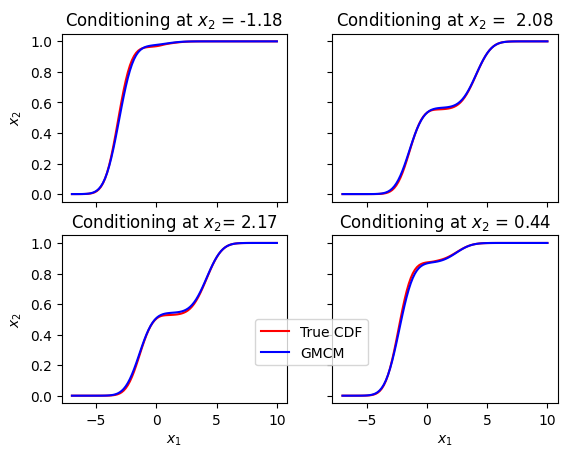

In [12]:
x_1 = r"x_{1}"
#z =latex2sympy(x_1)
x_55 = np.round(data_tst[55,1],2)
x_60 = np.round(data_tst[60,1],2)
x_2 = np.round(data_tst[2,1],2)
x_1 = np.round(data_tst[1,1],2)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(X, y_55, color="red", label="True CDF")
axs[0, 0].plot(X, Y_55, color="blue", label="GMCM")
axs[0, 0].set_title(r'Conditioning at $x_{2}$ = %s'%(x_55))
axs[0, 1].plot(X, y_1, color="red", label="True CDF")
axs[0, 1].plot(X, Y_1, color="blue", label="GMCM")
axs[0, 1].set_title(r'Conditioning at $x_{2}$ =  %s'%(x_1))
axs[1, 0].plot(X, y_2, color="red",label="True CDF")
axs[1, 0].plot(X, Y_2, color="blue", label="GMCM")
axs[1, 0].set_title('Conditioning at $x_{2}$= %s'%(x_2))
axs[1, 1].plot(X, y_60, color="red",label="True CDF")
axs[1, 1].plot(X, Y_60, color="blue", label="GMCM")
axs[1, 1].set_title('Conditioning at $x_{2}$ = %s'%(x_60))

for ax in axs.flat:
    ax.set(xlabel=r'$x_{1}$', ylabel=r'$x_{2}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.45,0.20))
plt.show()
#plt.savefig("simple_cdf_conditioning.png")

Competitors

In [13]:
n_comps=1
nsamps,ndims = df.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

gc= GMCM(ndims)
gc.fit_dist_IFM(data_trn,
                 n_comps=n_comps,
                 method="GC",
                 data_vld= None,# fixed number of components
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

Number of samples = 1000, Number of dimensions = 2
Learning Marginals
Marginals learnt in 1.53 s.


In [14]:
list_indexes = [0,1] ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(gc.ndims,gc.ncomps,gc.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,gc.ncomps)
for k in range(gc.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

In [15]:
data_trn_uniform = gc.marg_bijector.inverse(data_trn)
data_trn_latent = norm.ppf(data_trn_uniform)

In [16]:
data_trn_latent

array([[-1.66990864, -0.97892499],
       [ 0.20010726, -0.01193011],
       [-0.10808492,  0.45640692],
       ...,
       [ 0.99164671,  1.90208614],
       [-0.61436146, -0.10708898],
       [-1.30932212, -1.66625082]])

In [17]:
#cov_matrix = covs_new[0].numpy()
data_trn_uniform = gc.marg_bijector.inverse(data_trn)
data_trn_latent = norm.ppf(data_trn_uniform)
mean_vector = np.mean(data_trn_latent, axis=0)
cov_matrix = np.cov(data_trn_latent, rowvar=False)
Sigma22 = cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]
Sigma12 = cov_matrix[:dimension_predict, dimension_predict:dimension_joint]
Sigma11 = cov_matrix[:dimension_predict, :dimension_predict]
Sigma22_inv = np.linalg.inv(Sigma22)
Sigma12_Sigma22_inv = Sigma12 @ Sigma22_inv
cov_cond = Sigma11 - Sigma12_Sigma22_inv @ Sigma12.T
from scipy.stats import norm, multivariate_normal as mvn
method = "GC"
if method == "GC":
    data_tst_uniform = gc.marg_bijector.inverse(data_tst)
    data_tst_latent = norm.ppf(data_tst_uniform)
    #mean_vector = mus_new[0]
    #mean_vector = np.mean(data_trn_latent)
    #cov_matrix = n
    dimension_predict = 1 # dimension of the vector that we want to predict
    dimension_joint = 2 # dimension of the joint distribution
    size_test = np.shape(data_tst)[0] # size of the test dataset
    n_samples = 1000 # number of samples from the conditional distribution that we want to get
    cond_samples_gc = []
    #cov_matrix = covs_new[0]
    for index in range(data_tst_latent.shape[0]):
        risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
        conditioning_value = data_tst_latent[index,dimension_predict:dimension_joint]
        conditioning_diff = conditioning_value - mean_vector[dimension_predict:dimension_joint]
        conditioning_diff = conditioning_diff[:, np.newaxis]
        mean_cond_batch = mean_vector[:dimension_predict] + (Sigma12_Sigma22_inv @ conditioning_diff).flatten()
        # generate Normal data (in latent space) with required mean and sigma
        samples = np.random.multivariate_normal(mean = mean_cond_batch, cov = cov_cond, size = n_samples)
        risk_vector_gmcm[:, :dimension_predict] = samples
        risk_vector_gmcm[:,dimension_predict:dimension_joint] = conditioning_value
        risk_vector_gmcm = risk_vector_gmcm.astype('float32')
        risk_vector_gmcm = norm.cdf(risk_vector_gmcm).astype("float32")
        risk_vector_gmcm = gc.marg_bijector(risk_vector_gmcm)
        cond_samples_gc.append(risk_vector_gmcm)

In [18]:

n_comps=2
nsamps,ndims = df.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

tgmm = GMCM(ndims)
tgmm.fit_dist_IFM(data_trn,
                 n_comps=n_comps,
                 method="TGMM",
                 data_vld= None,# fixed number of components
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

Number of samples = 1000, Number of dimensions = 2
Learning Marginals
Marginals learnt in 1.59 s.


In [19]:
list_indexes = [0,1] ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(tgmm.ndims,tgmm.ncomps,tgmm.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,tgmm.ncomps)
for k in range(tgmm.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

In [20]:
method = "TGMM"
Sigma22_inv_list = []
Sigma12_Sigma22_inv_list = []
cov_cond_list = []
for j in range(n_comps):
    cov_matrix = covs_new[j].numpy()
    Sigma22 = cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]
    Sigma12 = cov_matrix[:dimension_predict, dimension_predict:dimension_joint]
    Sigma11 = cov_matrix[:dimension_predict, :dimension_predict]
    Sigma22_inv = np.linalg.inv(Sigma22)
    Sigma12_Sigma22_inv = Sigma12 @ Sigma22_inv
    cov_cond = Sigma11 - Sigma12_Sigma22_inv @ Sigma12.T
    Sigma12_Sigma22_inv_list.append(Sigma12_Sigma22_inv)
    cov_cond_list.append(cov_cond)
if method == "TGMM":
    data_tst_uniform = tgmm.marg_bijector.inverse(data_tst)
    data_tst_latent = norm.ppf(data_tst_uniform)
    dimension_predict = 1 # dimension of the vector that we want to predict
    dimension_joint = 2 # dimension of the joint distribution
    size_test = np.shape(data_tst)[0] # size of the test dataset
    n_samples = 1000 # number of samples from the conditional distribution that we want to get
    cond_samples_tgmm= []
    for i in range(0,size_test):
        risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
        conditioning_value = data_tst_latent[i,dimension_predict:dimension_joint]
        new_alphas = np.zeros(n_comps)
        # get new weights
        for j in range(0,n_comps):
            marginal = multivariate_normal.pdf(conditioning_value, mean= mus_new[j][dimension_predict:dimension_joint], 
                                           cov=covs_new[j][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
            joint = 0
            for k in range(0,n_comps):
                joint += alphas[k] * multivariate_normal.pdf(conditioning_value, mean= mus_new[k][dimension_predict:dimension_joint], 
                                           cov=covs_new[k][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
            if joint != 0:
                new_alphas[j] = alphas[j] * (marginal / joint)
            else:
                new_alphas[j] = 0
        new_alphas /= new_alphas.sum()
        component_choices = np.random.choice(n_comps, size = n_samples, p = new_alphas)
        risk_vector_gmcm = np.zeros((n_samples, dimension_joint))
        for j in range(0, n_comps):
            mask = component_choices == j
            n_j = np.sum(mask)
            if n_j == 0:
                continue
            mean_vector = mus_new[j].numpy()
            Sigma12_Sigma22_inv = Sigma12_Sigma22_inv_list[j]
            cov_cond = cov_cond_list[j]
            conditioning_diff = conditioning_value - mean_vector[dimension_predict:dimension_joint]
            conditioning_diff = conditioning_diff[:, np.newaxis]
            mean_cond_batch = mean_vector[:dimension_predict] + (Sigma12_Sigma22_inv @ conditioning_diff).flatten()
            # generate Normal data (in latent space) with required mean and sigma
            samples = np.random.multivariate_normal(mean = mean_cond_batch, cov = cov_cond, size = n_j)
            risk_vector_gmcm[mask, :dimension_predict] = samples
    
        risk_vector_gmcm[:, dimension_predict:dimension_joint] = conditioning_value
        risk_vector_gmcm = risk_vector_gmcm.astype('float32')
        risk_vector_gmcm = norm.cdf(risk_vector_gmcm).astype("float32")
        risk_vector_gmcm = tgmm.marg_bijector(risk_vector_gmcm)
        cond_samples_tgmm.append(risk_vector_gmcm)

In [21]:
from sklearn.neighbors import KernelDensity
# Split the training data
Y_train = np.reshape(data_trn[:, 0],(np.shape(data_trn)[0],1))  # First three columns (targets)
X_train = np.reshape(data_trn[:, 1],(np.shape(data_trn)[0],1))  # Last two columns (features)

# Combine both Y and X for KDE fitting
train_data = data_trn

# Split the test data
X_test = data_tst[:, 1]  # Last two columns in test data

#### Step 2: Fit KDE Model


# Fit the KDE model on the joint data
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(train_data)


#### Step 3: Generate Samples from the Conditional Distribution

def conditional_sample_kde(kde, X_cond, num_samples=10, tol=0.1):
    """
    Generate samples from the conditional distribution P(Y|X) using the fitted KDE.

    Parameters:
    kde -- fitted KernelDensity model
    X_cond -- ndarray of shape (n_samples, n_features)
    num_samples -- number of samples to draw for each condition
    tol -- tolerance to filter X samples close to X_cond

    Returns:
    samples -- ndarray of shape (n_samples, num_samples, n_targets)
    """
               
    n_targets = Y_train.shape[1]
    n_features = X_train.shape[1]
    
    samples = np.zeros((X_cond.shape[0], num_samples, n_targets))

    for i, x in enumerate(X_cond):
        # Generate samples from KDE
        joint_samples = kde.sample(num_samples * 100)  # Oversample initially
        
        # Split into Y and X parts
        Y_samples = joint_samples[:, :n_targets]
        X_samples = joint_samples[:, n_targets:]
        
        # Filter samples where X_samples are close to the given X_cond
        close_samples_idx = np.all(np.abs(X_samples - x) < tol, axis=1)
        close_Y_samples = Y_samples[close_samples_idx]
        
        if len(close_Y_samples) < num_samples:
            raise ValueError("Not enough samples within tolerance. Increase tol or num_samples.")

        # Randomly choose the needed number of samples
        chosen_indices = np.random.choice(len(close_Y_samples), num_samples, replace=False)
        samples[i, :, :] = close_Y_samples[chosen_indices]

    return samples

# Generate samples from the conditional distribution
num_samples_per_condition = 1000 # Number of samples to draw for each test example
tol = 0.4# Tolerance to filter samples; adjust as needed
samples = conditional_sample_kde(kde, X_test, num_samples=num_samples_per_condition, tol=tol)

In [22]:
def logs_ensemble(obs, fct, m_axis=-1, bw=None):
    # Move ensemble dimension to the last axis if not already
    fct = np.moveaxis(fct, m_axis, -1)
    M = fct.shape[-1]

    # Silverman's rule of thumb for bandwidth if not provided
    if bw is None:
        sigmahat = np.std(fct, axis=-1)
        q75 = np.quantile(fct, 0.75, axis=-1)
        q25 = np.quantile(fct, 0.25, axis=-1)
        iqr = q75 - q25
        bw = 1.06 * np.minimum(sigmahat, iqr / 1.34) * (M ** (-1 / 5))
        
    bw = np.repeat(bw[..., np.newaxis], M, axis=-1)

    # Weights for each ensemble member
    w = np.ones(fct.shape) / M

    # Compute Gaussian log density
    def gaussian_log_pdf(x, mean, scale):
        return -0.5 * np.log(2 * np.pi * scale**2) - ((x - mean) ** 2) / (2 * scale**2)

    # Logarithmic score calculation for each observation
    log_scores = np.empty_like(obs, dtype=float)
    for i, x in np.ndenumerate(obs):
        log_density = np.log(np.sum(
            w[i] * np.exp(gaussian_log_pdf(x, fct[i], bw[i]))
        ))
        log_scores[i] = log_density

    return -log_scores

In [23]:
import scoringrules as sr
crps_score_gmcm = []
logs_score_gmcm = []
logs_score_gc = []
logs_score_tgmm = []
crps_score_gc = []
logs_score_ckde = []
crps_score_ckde= []
crps_score_tgmm = []
for i in range(size_test):
    crps_score_gmcm.append(sr.crps_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_gmcm[i][:,0:dimension_predict])))
    logs_score_gmcm.append(logs_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_gmcm[i][:,0:dimension_predict])))
    crps_score_gc.append(sr.crps_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_gc[i][:,0:dimension_predict])))
    logs_score_gc.append(logs_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_gc[i][:,0:dimension_predict])))
    crps_score_tgmm.append(sr.crps_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_tgmm[i][:,0:dimension_predict])))
    logs_score_tgmm.append(logs_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(cond_samples_tgmm[i][:,0:dimension_predict])))
    crps_score_ckde.append(sr.crps_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(samples[i])))
    logs_score_ckde.append(logs_ensemble(data_tst[i,0:dimension_predict],
    np.transpose(samples[i])))

In [24]:
np.mean(crps_score_gmcm)

1.2783068127846897

In [25]:
np.mean(logs_score_gmcm)

1.8725478692511677

In [26]:
np.mean(crps_score_ckde)

1.3745386692508978

In [27]:
np.mean(crps_score_gc)

1.2743953235450853

In [28]:
np.mean(crps_score_tgmm)

1.2819320656296835

In [29]:
np.mean(logs_score_gc)

1.9060124843457844

In [30]:
np.mean(crps_score_ckde)

1.3745386692508978

In [31]:
np.mean(logs_score_ckde)

2.118635820174284